Using TensorFlow backend.


Columns before removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Tmperature out
Col. 6 : PI0001 - Cooling side Pressure in
Col. 7 : FI0027 - Cooling side flow rate
Col. 8 : TIC0022U - Cooling side valve opening
Col. 9 : PDT0024 - Cooling side dP

Columns after removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model lstmr 128 was loaded from file
Model lstmr 2x 64 was loaded from file
+-------------+-----------+-------------+---------------+--------+
|    Model    | Min. loss | Chosen loss | M

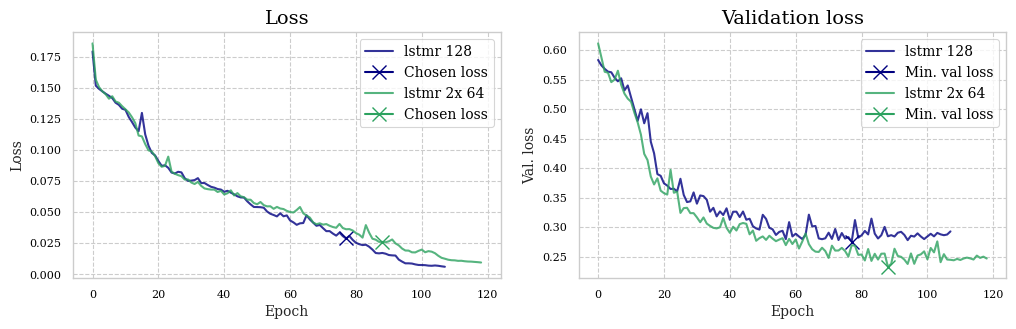

Model prediction scores
+-------------+-------------+------------+
|    Model    | Train score | Test score |
+-------------+-------------+------------+
|  lstmr 128  |    0.7387   |   -0.644   |
| lstmr 2x 64 |    0.7621   |  -0.7166   |
+-------------+-------------+------------+


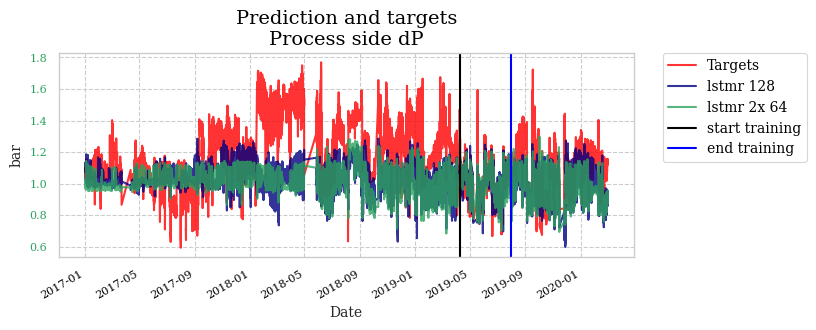

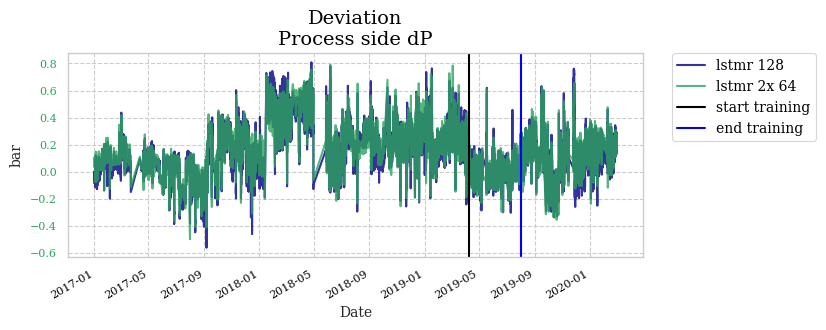

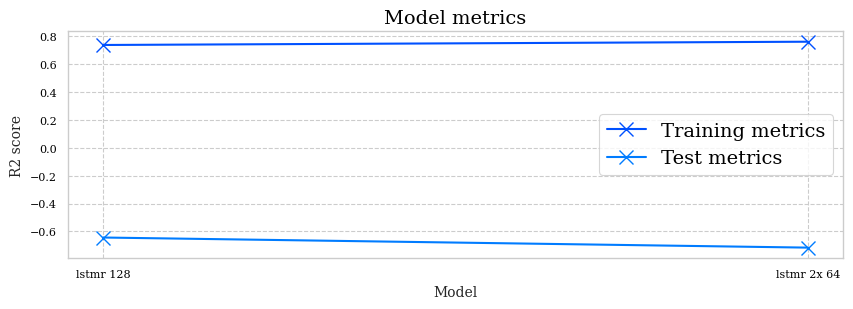

In [1]:
# %load example_G_basic.py
import statApi
from api import Api
mlApi = Api()

# define dataset specifics
filename = "../master-thesis-db/datasets/G/data_30min.csv"

columns = [
	['PDI0064', 'Process side dP', 'bar'],
	['TI0066', 'Process side Temperature out','degrees'],
	['TZI0012', 'Process side Temperature in', 'degrees'],
	['FI0010', 'Process side flow rate', 'MSm^3/d(?)'],
	['TT0025', 'Cooling side Temperature in', 'degrees'],
	['TT0026', 'Cooling side Tmperature out', 'degrees'],
	['PI0001', 'Cooling side Pressure in', 'barG'],
	['FI0027', 'Cooling side flow rate', 'MSm^3/d(?)'],
	['TIC0022U', 'Cooling side valve opening', '%'],
	['PDT0024', 'Cooling side dP', 'bar'],
]

irrelevantColumns = [
	'TIC0022U',
	'FI0027',
	'PDT0024',
	'PI0001',
	'TT0025',
	'TT0026',
]

targetColumns = [
    'PDI0064'
]

traintime = [
	["2019-04-10 00:00:00", "2019-08-01 00:00:00"]
]

testtime = [
	"2017-01-01 00:00:00",
	"2020-03-01 00:00:00",
]

df = mlApi.initDataframe(filename, columns, irrelevantColumns)
df_train, df_test = mlApi.getTestTrainSplit(traintime, testtime)
X_train, y_train, X_test, y_test = mlApi.getFeatureTargetSplit(targetColumns)

linear = mlApi.Linear('linear')
linear_r = mlApi.Linear_Regularized('linear r')

mlpd_1x_128 = mlApi.MLP('mlpd 128', layers=[128], dropout=0.2, epochs=1000)
lstmd_1x_128 = mlApi.LSTM('lstmr 128', layers=[128], dropout=0.2, recurrentDropout=0.2, training=False, epochs=500, batchSize=128*2, enrolWindow=16)

mlpd_2x_64 = mlApi.MLP('mlpd 2x 64', layers=[64, 64], dropout=0.2, epochs=1000)
lstmd_2x_64 = mlApi.LSTM('lstmr 2x 64', layers=[64, 64], dropout=0.2, recurrentDropout=0.2, training=False, epochs=500, batchSize=128*2, enrolWindow=16)

modelList = [
	#linear_r,
	#mlpd_1x_128,
	lstmd_1x_128,
	#mlpd_2x_64,
	lstmd_2x_64,
	#linear,
]

mlApi.initModels(modelList)
retrain=False
mlApi.trainModels(retrain)
modelNames, metrics_train, metrics_test, columnsList, deviationsList = mlApi.predictWithModels(
	plot=True,
	interpol=False,
)